# Reconocimiento de caras de animales
Voy a seguir el flujo que vimos en clase: preparo las imágenes, saco descriptores HOG, juego con un clustering para ver cómo se reparten y termino con un clasificador en un pipeline completo.

## Pasos que me propongo
1. Listar automáticamente todas las carpetas del dataset para usar todas las imágenes disponibles.
2. Pasar las fotos a escala de grises, hacerles `resize` y guardarlas aparte.
3. Guardar un dataset intermedio con joblib (la profe pidió un pickle).
4. Calcular HOG y mirar un clustering con una gráfica sencilla.
5. Montar un pipeline con KernelPCA (KPE), hacer GridSearch con validación cruzada, clasificar y sacar una matriz de confusión basada en la validación cruzada.

In [25]:
from pathlib import Path
import random

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from PIL import Image, ImageOps, UnidentifiedImageError

from skimage.feature import hog

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

random.seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_theme()

In [26]:
BASE_DIR = Path('.').resolve()
DATA_DIR = BASE_DIR / 'AnimalFace' / 'Image'
PROCESSED_DIR = BASE_DIR / 'AnimalFace' / 'processed_64_gray'
OUTPUT_DIR = BASE_DIR / 'AnimalFace' / 'outputs'

IMAGE_SIZE = (64, 64)

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

if not DATA_DIR.exists():
    raise FileNotFoundError(f'No encontré la carpeta de imágenes en {DATA_DIR}')

CATEGORIES = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
print(f'Trabajo con {len(CATEGORIES)} clases: {CATEGORIES}')

Trabajo con 21 clases: ['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'Natural', 'PandaHead', 'PigHead', 'PigeonHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


### Funciones de apoyo
Todo lo que reutilizo lo meto en helpers sencillos para no repetir código.

In [27]:
from typing import List, Tuple


def collect_image_paths(class_name: str) -> List[Path]:
    folder = DATA_DIR / class_name
    supported = []
    for pattern in ('*.jpg', '*.jpeg', '*.png', '*.bmp'):
        supported.extend(folder.glob(pattern))
    return sorted(supported)


def preprocess_image(path: Path, size: Tuple[int, int]) -> np.ndarray:
    try:
        with Image.open(path) as image:
            image = ImageOps.exif_transpose(image)
            image = ImageOps.grayscale(image)
            image = image.resize(size, Image.Resampling.LANCZOS)
            array = np.asarray(image, dtype=np.float32) / 255.0
    except (UnidentifiedImageError, OSError) as exc:
        raise ValueError(f'No pude cargar {path}') from exc
    return array


def preprocess_image_color(path: Path, size: Tuple[int, int]) -> np.ndarray:
    try:
        with Image.open(path) as image:
            image = ImageOps.exif_transpose(image)
            image = image.convert('RGB')
            image = image.resize(size, Image.Resampling.LANCZOS)
            array = np.asarray(image, dtype=np.float32) / 255.0
    except (UnidentifiedImageError, OSError) as exc:
        raise ValueError(f'No pude cargar {path}') from exc
    return array


def save_preprocessed_image(array: np.ndarray, original_path: Path) -> Path:
    label = original_path.parent.name
    save_dir = PROCESSED_DIR / label
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f"{original_path.stem}_64_gray.png"
    image_to_save = Image.fromarray((array * 255).astype(np.uint8))
    image_to_save.save(save_path)
    return save_path


def build_dataset_descriptor() -> pd.DataFrame:
    rows = []
    skipped = 0
    for label in CATEGORIES:
        paths = collect_image_paths(label)
        for path in paths:
            try:
                processed = preprocess_image(path, IMAGE_SIZE)
            except ValueError:
                print(f"Salté {path.name} porque PIL no la reconoce bien.")
                skipped += 1
                continue
            saved_path = save_preprocessed_image(processed, path)
            rows.append({
                'label': label,
                'original_path': path.as_posix(),
                'processed_path': saved_path.as_posix()
            })
    df = pd.DataFrame(rows)
    df = df.sort_values('label').reset_index(drop=True)
    if skipped:
        print(f"Salté {skipped} imágenes que estaban dañadas o con formato raro.")
    return df


def show_before_after(df: pd.DataFrame, samples: int = 4) -> None:
    subset = df.groupby('label').head(1)
    subset = subset.sample(min(samples, len(subset)), random_state=42)
    fig, axes = plt.subplots(len(subset), 2, figsize=(6, 3 * len(subset)))
    if len(subset) == 1:
        axes = np.array([axes])
    for (idx, row), (ax_orig, ax_proc) in zip(subset.iterrows(), axes):
        orig = Image.open(row['original_path'])
        proc = Image.open(row['processed_path'])
        ax_orig.imshow(orig)
        ax_orig.set_title(f"{row['label']} original")
        ax_orig.axis('off')
        ax_proc.imshow(proc, cmap='gray')
        ax_proc.set_title('Preprocesada 64x64 gris')
        ax_proc.axis('off')
    plt.tight_layout()
    plt.show()


def hog_from_array(image_array: np.ndarray,
                   orientations: int = 9,
                   pixels_per_cell: Tuple[int, int] = (8, 8),
                   cells_per_block: Tuple[int, int] = (2, 2)) -> np.ndarray:
    return hog(
        image_array,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        feature_vector=True
    )


def load_hog_features(df: pd.DataFrame,
                      orientations: int = 9,
                      pixels_per_cell: Tuple[int, int] = (8, 8),
                      cells_per_block: Tuple[int, int] = (2, 2)) -> np.ndarray:
    features = []
    for path in df['processed_path']:
        image = Image.open(path)
        array = np.asarray(image, dtype=np.float32) / 255.0
        features.append(hog_from_array(array, orientations, pixels_per_cell, cells_per_block))
    return np.vstack(features)



class ImageToColorHog(BaseEstimator, TransformerMixin):
    def __init__(self, image_size: Tuple[int, int] = IMAGE_SIZE,
                 orientations: int = 9,
                 pixels_per_cell: Tuple[int, int] = (8, 8),
                 cells_per_block: Tuple[int, int] = (2, 2)):
        self.image_size = image_size
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for path in X:
            array = preprocess_image_color(Path(path), self.image_size)
            channel_features = [
                hog_from_array(
                    array[..., channel],
                    orientations=self.orientations,
                    pixels_per_cell=self.pixels_per_cell,
                    cells_per_block=self.cells_per_block
                )
                for channel in range(array.shape[-1])
            ]
            features.append(np.concatenate(channel_features, axis=0))
        return np.vstack(features)


class ImageToHog(BaseEstimator, TransformerMixin):
    def __init__(self, image_size: Tuple[int, int] = IMAGE_SIZE,
                 orientations: int = 9,
                 pixels_per_cell: Tuple[int, int] = (8, 8),
                 cells_per_block: Tuple[int, int] = (2, 2)):
        self.image_size = image_size
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for path in X:
            array = preprocess_image(Path(path), self.image_size)
            features.append(hog_from_array(
                array,
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block
            ))
        return np.vstack(features)

### Preparo el dataset completo
Ahora recorro todas las carpetas y guardo la versión 64x64 en gris para no tener que regenerarla cada vez.

      label                                      original_path  \
0  BearHead  /home/ruben/EC/EC/src/animal_face/AnimalFace/I...   
1  BearHead  /home/ruben/EC/EC/src/animal_face/AnimalFace/I...   
2  BearHead  /home/ruben/EC/EC/src/animal_face/AnimalFace/I...   
3  BearHead  /home/ruben/EC/EC/src/animal_face/AnimalFace/I...   
4  BearHead  /home/ruben/EC/EC/src/animal_face/AnimalFace/I...   

                                      processed_path  
0  /home/ruben/EC/EC/src/animal_face/AnimalFace/p...  
1  /home/ruben/EC/EC/src/animal_face/AnimalFace/p...  
2  /home/ruben/EC/EC/src/animal_face/AnimalFace/p...  
3  /home/ruben/EC/EC/src/animal_face/AnimalFace/p...  
4  /home/ruben/EC/EC/src/animal_face/AnimalFace/p...  

label
DogHead         389
CatHead         160
PandaHead       116
TigerHead       112
DuckHead        102
PigHead         101
DeerHead        101
CowHead         101
BearHead        101
ChickenHead     100
MouseHead       100
ElephantHead    100
HumanHead       100
SheepH

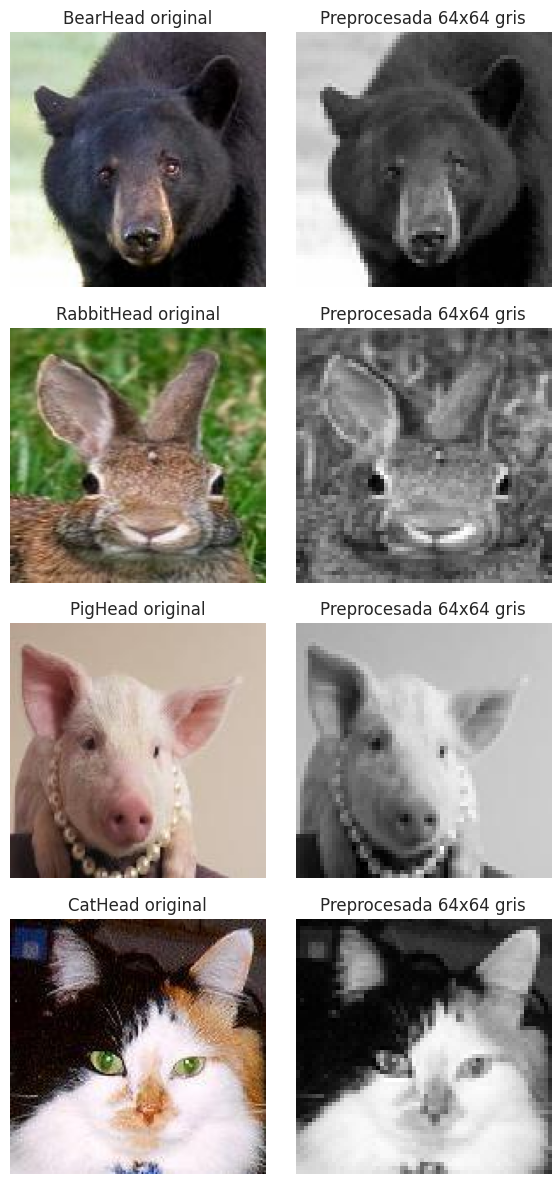

Descriptor guardado en /home/ruben/EC/EC/src/animal_face/AnimalFace/outputs/dataset_descriptor.joblib


In [28]:
dataset_df = build_dataset_descriptor()
print(dataset_df.head())
print()
print(dataset_df['label'].value_counts())

show_before_after(dataset_df)

joblib.dump(dataset_df, OUTPUT_DIR / 'dataset_descriptor.joblib')
print(f"Descriptor guardado en {OUTPUT_DIR / 'dataset_descriptor.joblib'}")

### HOG + KPE (KernelPCA) + clustering
Uso KernelPCA como la parte "KPE" que nos comentó la profe y luego miro un KMeans para ver cómo quedan los grupos en las características HOG.

HOG guardado en /home/ruben/EC/EC/src/animal_face/AnimalFace/outputs/hog_features.joblib
Conteo por cluster:
0     108
1     243
2     107
3     164
4     181
5     173
6     116
7     124
8      58
9     135
10     62
11     53
12     70
13     30
14    142
15    103
16     54
17    111
18     27
19    129
20    193
Name: count, dtype: int64


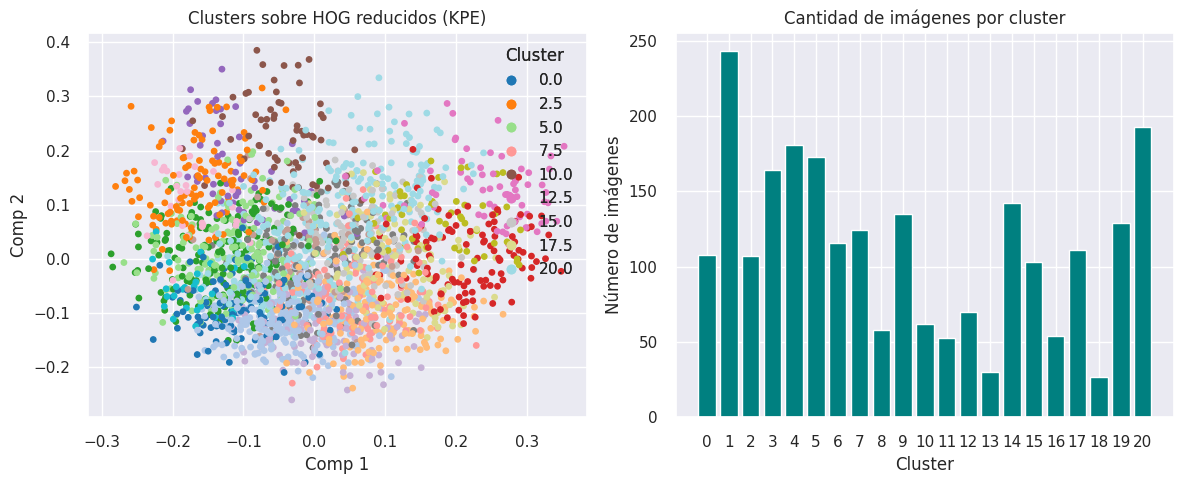

In [29]:
hog_features = load_hog_features(dataset_df)

joblib.dump({
    'hog_features': hog_features,
    'labels': dataset_df['label'].to_numpy(),
    'paths': dataset_df['processed_path'].to_numpy()
}, OUTPUT_DIR / 'hog_features.joblib')

print(f"HOG guardado en {OUTPUT_DIR / 'hog_features.joblib'}")

kpca_viz = KernelPCA(n_components=2, kernel='rbf', gamma=0.03, random_state=42)
hog_reduced = kpca_viz.fit_transform(hog_features)

kmeans = KMeans(n_clusters=len(CATEGORIES), random_state=42, n_init='auto')
clusters = kmeans.fit_predict(hog_features)

cluster_counts = pd.Series(clusters).value_counts().sort_index()
print('Conteo por cluster:')
print(cluster_counts)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
scatter = axes[0].scatter(hog_reduced[:, 0], hog_reduced[:, 1], c=clusters, cmap='tab20', s=15)
axes[0].set_title('Clusters sobre HOG reducidos (KPE)')
axes[0].set_xlabel('Comp 1')
axes[0].set_ylabel('Comp 2')
legend1 = axes[0].legend(*scatter.legend_elements(), title='Cluster', loc='best')
axes[0].add_artist(legend1)

axes[1].bar(cluster_counts.index, cluster_counts.values, color='teal')
axes[1].set_xticks(cluster_counts.index)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Número de imágenes')
axes[1].set_title('Cantidad de imágenes por cluster')

plt.tight_layout()
plt.show()

### Pipeline con GridSearch y validación cruzada
Armo el pipeline con: preprocesado → HOG → KernelPCA → escalado → SVM, hago el GridSearch con todo el dataset y validación cruzada y guardo el mejor modelo junto con los resultados.

In [30]:
X = dataset_df['original_path'].to_numpy()
y = dataset_df['label'].to_numpy()

pipeline = Pipeline([
    ('hog', ImageToHog()),
    ('kpca', KernelPCA(kernel='rbf', n_components=30, gamma=0.03, fit_inverse_transform=False, random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=False, random_state=42))
])

param_grid = {
    'hog__orientations': [8, 9],
    'hog__pixels_per_cell': [(8, 8), (16, 16)],
    'kpca__n_components': [20, 30, 40],
    'kpca__gamma': [0.01, 0.03],
    'clf__C': [1, 5, 10],
    'clf__gamma': ['scale', 0.01]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X, y)

print('Mejor score CV:', grid_search.best_score_)
print('Mejores parámetros:', grid_search.best_params_)

best_model = grid_search.best_estimator_

joblib.dump(best_model, OUTPUT_DIR / 'animal_face_pipeline.joblib')
joblib.dump(grid_search.cv_results_, OUTPUT_DIR / 'grid_search_results.joblib')
print(f"Modelo guardado en {OUTPUT_DIR / 'animal_face_pipeline.joblib'}")
print(f"Resultados CV guardados en {OUTPUT_DIR / 'grid_search_results.joblib'}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END clf__C=1, clf__gamma=scale, hog__orientations=8, hog__pixels_per_cell=(8, 8), kpca__gamma=0.01, kpca__n_components=20; total time=   8.5s
[CV] END clf__C=1, clf__gamma=scale, hog__orientations=8, hog__pixels_per_cell=(8, 8), kpca__gamma=0.03, kpca__n_components=20; total time=   8.6s
[CV] END clf__C=1, clf__gamma=scale, hog__orientations=8, hog__pixels_per_cell=(8, 8), kpca__gamma=0.01, kpca__n_components=30; total time=   8.7s
[CV] END clf__C=1, clf__gamma=scale, hog__orientations=8, hog__pixels_per_cell=(8, 8), kpca__gamma=0.01, kpca__n_components=40; total time=   8.7s
[CV] END clf__C=1, clf__gamma=scale, hog__orientations=8, hog__pixels_per_cell=(8, 8), kpca__gamma=0.01, kpca__n_components=30; total time=   8.7s
[CV] END clf__C=1, clf__gamma=scale, hog__orientations=8, hog__pixels_per_cell=(8, 8), kpca__gamma=0.01, kpca__n_components=20; total time=   8.7s[CV] END clf__C=1, clf__gamma=scale, hog__orientations=8

### Pipeline en color con HOG por canal

Añado un pipeline que reutiliza la estrategia sobre HOG pero conservando las tres bandas RGB. Ajusto una búsqueda de hiperparámetros más contenida para mantener los tiempos razonables.

In [31]:
color_pipeline = Pipeline([
    ('hog', ImageToColorHog()),
    ('kpca', KernelPCA(kernel='rbf', n_components=40, gamma=0.02, random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=False, random_state=42))
])

color_param_grid = {
    'hog__orientations': [8, 9],
    'kpca__n_components': [40, 55],
    'kpca__gamma': [0.01, 0.02, 0.03],
    'clf__C': [5, 10],
    'clf__gamma': ['scale', 0.01]
}

color_grid_search = GridSearchCV(
    color_pipeline,
    param_grid=color_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

color_grid_search.fit(X, y)

print('Mejor score CV (color):', color_grid_search.best_score_)
print('Mejores parámetros (color):', color_grid_search.best_params_)

color_best_model = color_grid_search.best_estimator_

joblib.dump(color_best_model, OUTPUT_DIR / 'animal_face_pipeline_color.joblib')
joblib.dump(color_grid_search.cv_results_, OUTPUT_DIR / 'grid_search_results_color.joblib')
print(f"Modelo en color guardado en {OUTPUT_DIR / 'animal_face_pipeline_color.joblib'}")
print(f"Resultados CV color guardados en {OUTPUT_DIR / 'grid_search_results_color.joblib'}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.01, kpca__n_components=55; total time=  18.8s
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.01, kpca__n_components=55; total time=  18.9s
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.02, kpca__n_components=40; total time=  19.1s
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.01, kpca__n_components=40; total time=  19.2s
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.01, kpca__n_components=40; total time=  19.6s
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.02, kpca__n_components=40; total time=  19.6s
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.01, kpca__n_components=40; total time=  19.7s
[CV] END clf__C=5, clf__gamma=scale, hog__orientations=8, kpca__gamma=0.02, kpca__n_components=40; total time=  

=== Reporte Grises (HOG) ===
              precision    recall  f1-score   support

    BearHead       0.78      0.73      0.76       101
     CatHead       0.84      0.79      0.81       160
 ChickenHead       0.79      0.85      0.82       100
     CowHead       0.69      0.68      0.69       101
    DeerHead       0.80      0.91      0.85       101
     DogHead       0.64      0.84      0.73       389
    DuckHead       0.93      0.78      0.85       102
   EagleHead       0.81      0.65      0.72        97
ElephantHead       0.85      0.81      0.83       100
   HumanHead       0.98      0.93      0.95       100
    LionHead       0.75      0.78      0.77        97
  MonkeyHead       0.76      0.68      0.72       100
   MouseHead       0.70      0.62      0.66       100
     Natural       0.00      0.00      0.00         8
   PandaHead       0.91      0.91      0.91       116
     PigHead       0.56      0.50      0.53       101
  PigeonHead       0.79      0.77      0.78        9

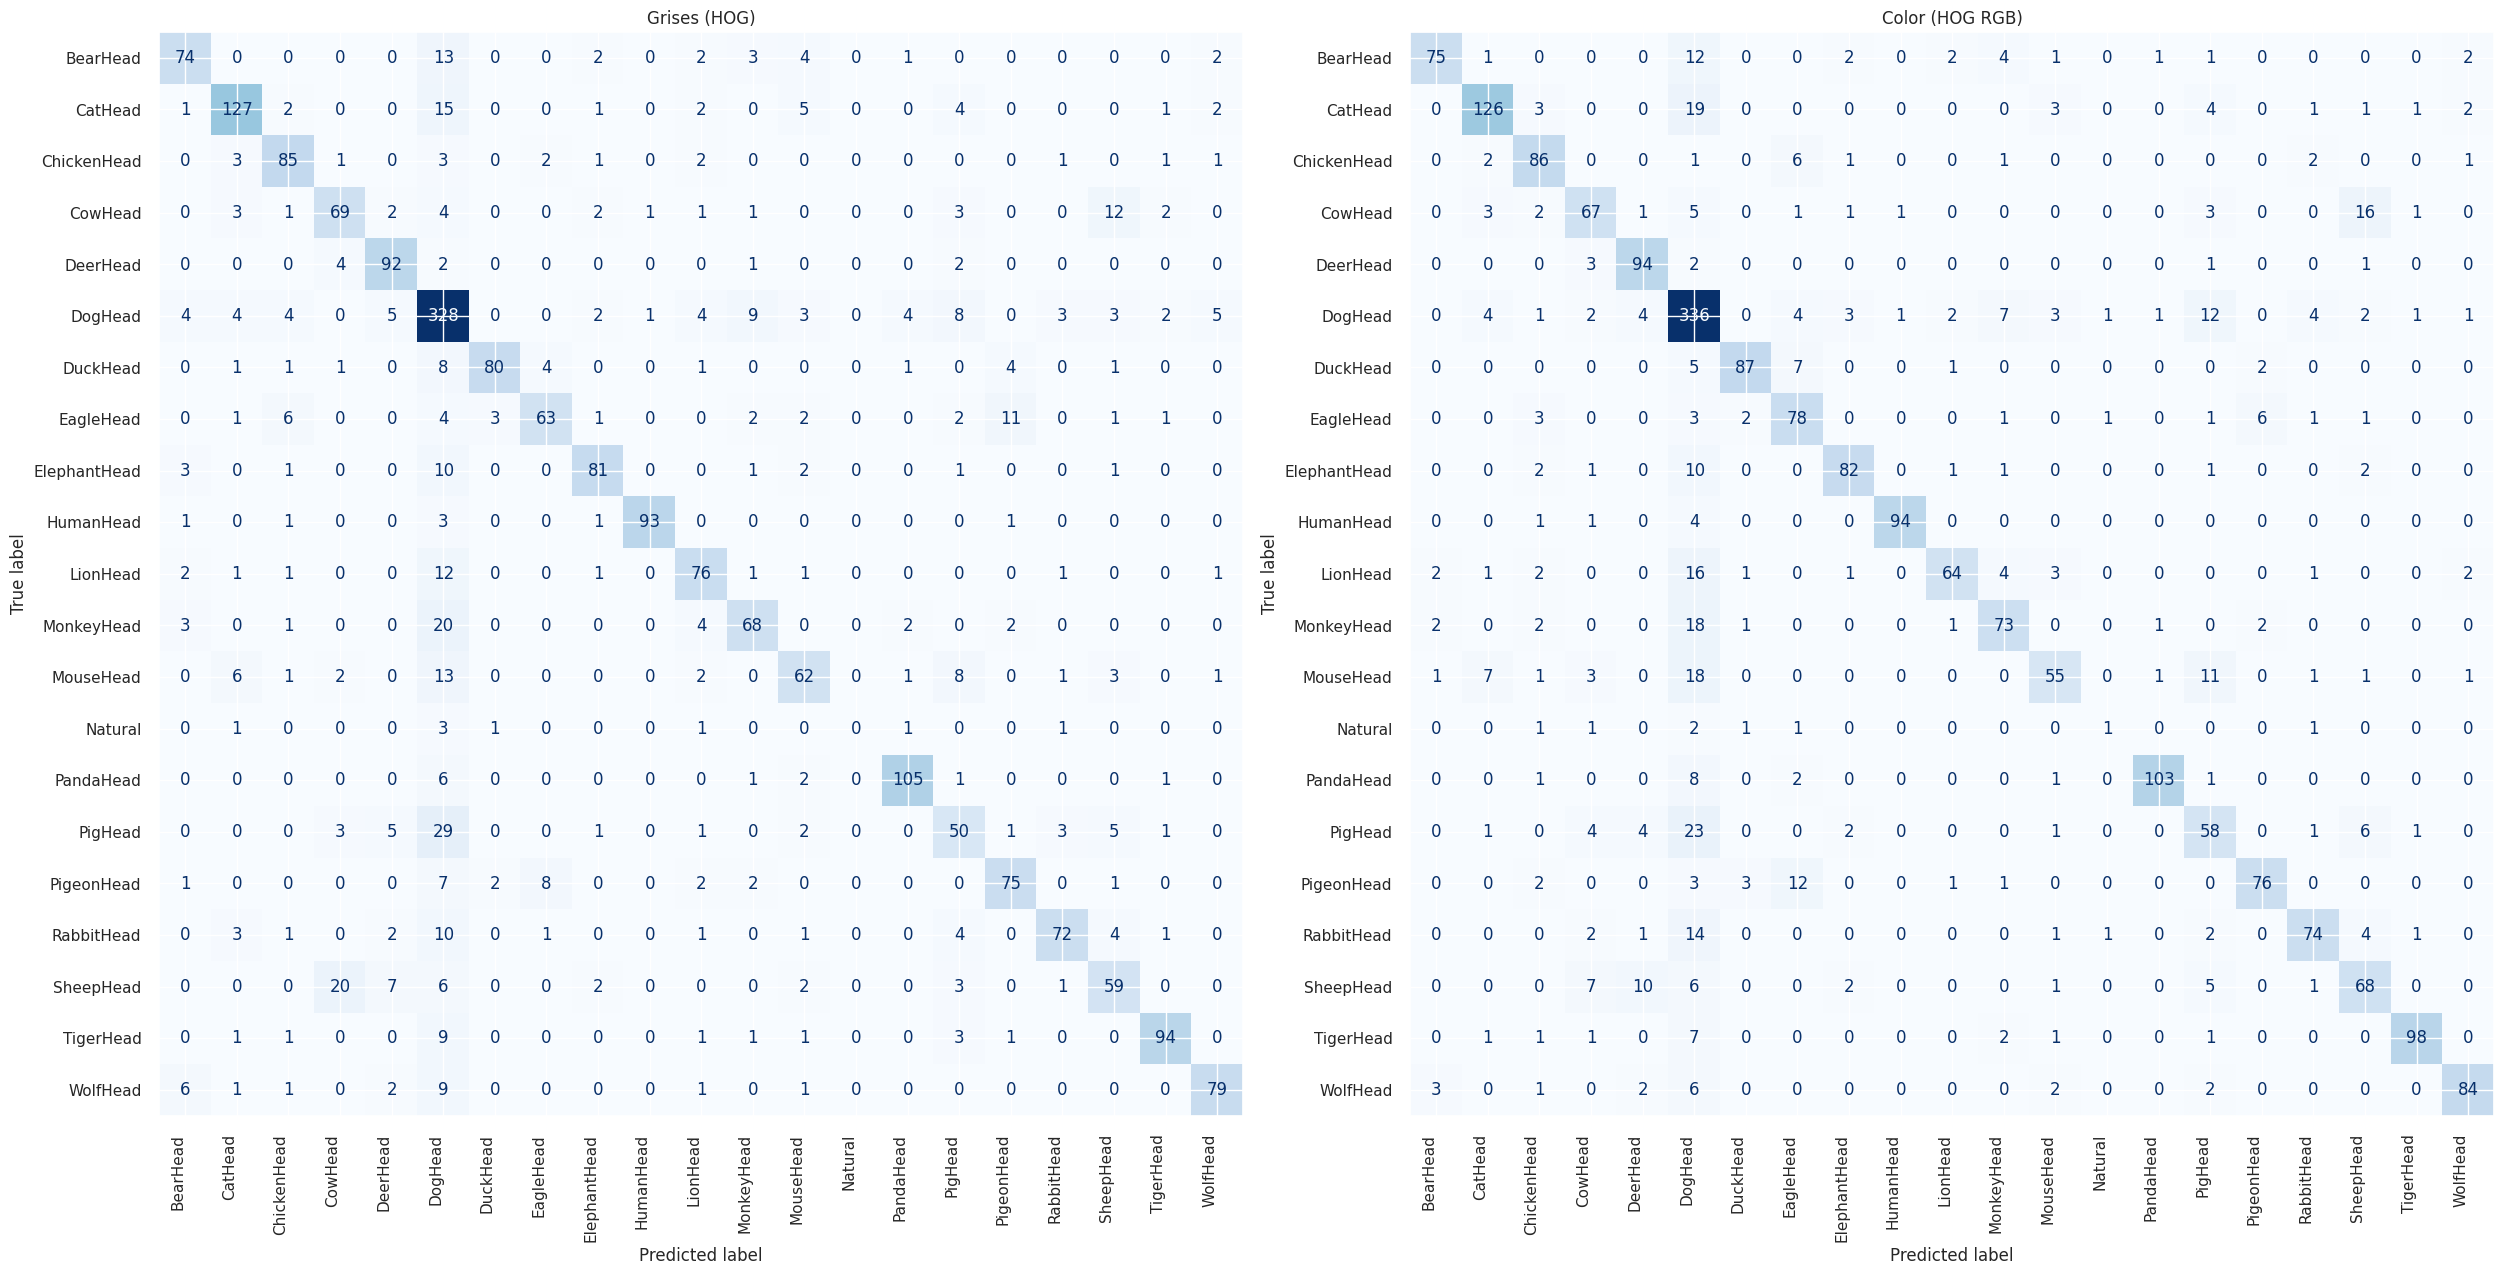

In [32]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Grises (HOG)': best_model,
    'Color (HOG RGB)': color_best_model
}

metrics_summary = []
predictions = {}

for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=cv_strategy, n_jobs=-1)
    predictions[name] = y_pred
    report = classification_report(y, y_pred, output_dict=True, zero_division=0)
    metrics_summary.append({
        'modelo': name,
        'accuracy': report['accuracy'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score']
    })
    print(f'=== Reporte {name} ===')
    print(classification_report(y, y_pred, zero_division=0))
    print()

summary_df = pd.DataFrame(metrics_summary).set_index('modelo')
display(summary_df.style.format('{:.3f}'))

num_models = len(models)
num_classes = len(best_model.classes_)
fig, axes = plt.subplots(1, num_models, figsize=(max(10, num_classes * 1.2), max(6, num_classes * 0.6)))
if num_models == 1:
    axes = [axes]

for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y, predictions[name], labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    rotation = 90 if num_classes > 10 else 45
    disp.ax_.set_xticklabels(model.classes_, rotation=rotation, ha='right')
    disp.ax_.set_yticklabels(model.classes_)
    ax.set_title(name)

plt.tight_layout()
plt.show()


### SGDClassifier

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=8; total time=  15.1s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=8; total time=  15.4s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=8; total time=  15.4s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=8; total time=  15.7s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=9; total time=  15.8s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=9; total time=  16.2s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=8; total time=  16.3s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=hinge, hog__orientations=9; total time=  16.5s
[CV] END clf__alpha=0.0001, clf__l1_ratio=0.1, clf__loss=log_loss, hog__orientations=8; total time=  16.6s


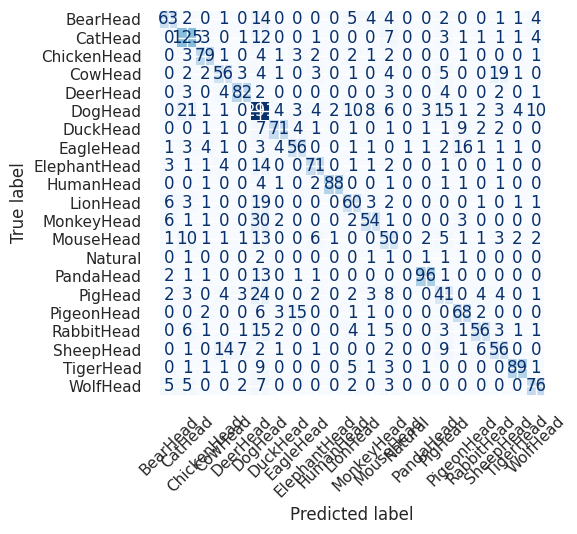

In [33]:
# Clasificador SGD con HOG y validación cruzada
from sklearn.linear_model import SGDClassifier

sgd_pipeline = Pipeline([
    ('hog', ImageToHog()),
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(
        loss='log_loss',
        penalty='elasticnet',
        alpha=1e-4,
        l1_ratio=0.15,
        learning_rate='optimal',
        max_iter=3000,
        tol=1e-4,
        random_state=42
    ))
])

sgd_param_grid = {
    'hog__orientations': [8, 9],
    'clf__loss': ['hinge', 'log_loss'],
    'clf__alpha': [1e-4, 5e-4],
    'clf__l1_ratio': [0.1, 0.2]
}

sgd_grid_search = GridSearchCV(
    sgd_pipeline,
    param_grid=sgd_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

sgd_grid_search.fit(X, y)

print('Mejor score CV (SGD):', sgd_grid_search.best_score_)
print('Mejores parámetros (SGD):', sgd_grid_search.best_params_)

sgd_best_model = sgd_grid_search.best_estimator_

joblib.dump(sgd_best_model, OUTPUT_DIR / 'animal_face_pipeline_sgd.joblib')
joblib.dump(sgd_grid_search.cv_results_, OUTPUT_DIR / 'grid_search_results_sgd.joblib')
print(f"Modelo SGD guardado en {OUTPUT_DIR / 'animal_face_pipeline_sgd.joblib'}")
print(f"Resultados CV SGD guardados en {OUTPUT_DIR / 'grid_search_results_sgd.joblib'}")

sgd_cv_predictions = cross_val_predict(
    sgd_best_model,
    X,
    y,
    cv=cv_strategy,
    n_jobs=-1
)

print('=== Reporte SGDClassifier ===')
print(classification_report(y, sgd_cv_predictions, zero_division=0))

sgd_cm = confusion_matrix(y, sgd_cv_predictions, labels=sgd_best_model.classes_)
sgd_disp = ConfusionMatrixDisplay(confusion_matrix=sgd_cm, display_labels=sgd_best_model.classes_)
sgd_disp.plot(cmap='Blues', colorbar=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Enseñar resultados raros

Grises (HOG): 551 ejemplos mal clasificados (se muestran combinaciones más raras).


frecuencia
actual→predicted                      
LionHead → ElephantHead              1
ChickenHead → ElephantHead           1
CowHead → ChickenHead                1
CowHead → MonkeyHead                 1
CatHead → BearHead                   1
ChickenHead → WolfHead               1
CatHead → ElephantHead               1
ChickenHead → CowHead                1
DeerHead → MonkeyHead                1
CatHead → TigerHead                  1

Color (HOG RGB): 504 ejemplos mal clasificados (se muestran combinaciones más raras).


frecuencia
actual→predicted                   
CowHead → DeerHead                1
MonkeyHead → LionHead             1
MonkeyHead → PandaHead            1
LionHead → ElephantHead           1
LionHead → CatHead                1
MonkeyHead → DuckHead             1
LionHead → DuckHead               1
EagleHead → PigHead               1
EagleHead → Natural               1
ElephantHead → PigHead            1

SGDClassifier: 755 ejemplos mal clasificados (se muestran combinaciones más raras).


frecuencia
actual→predicted                   
DuckHead → PandaHead              1
DuckHead → MouseHead              1
DuckHead → ElephantHead           1
DuckHead → LionHead               1
DuckHead → CowHead                1
EagleHead → PandaHead             1
EagleHead → BearHead              1
EagleHead → LionHead              1
EagleHead → Natural               1
LionHead → ChickenHead            1

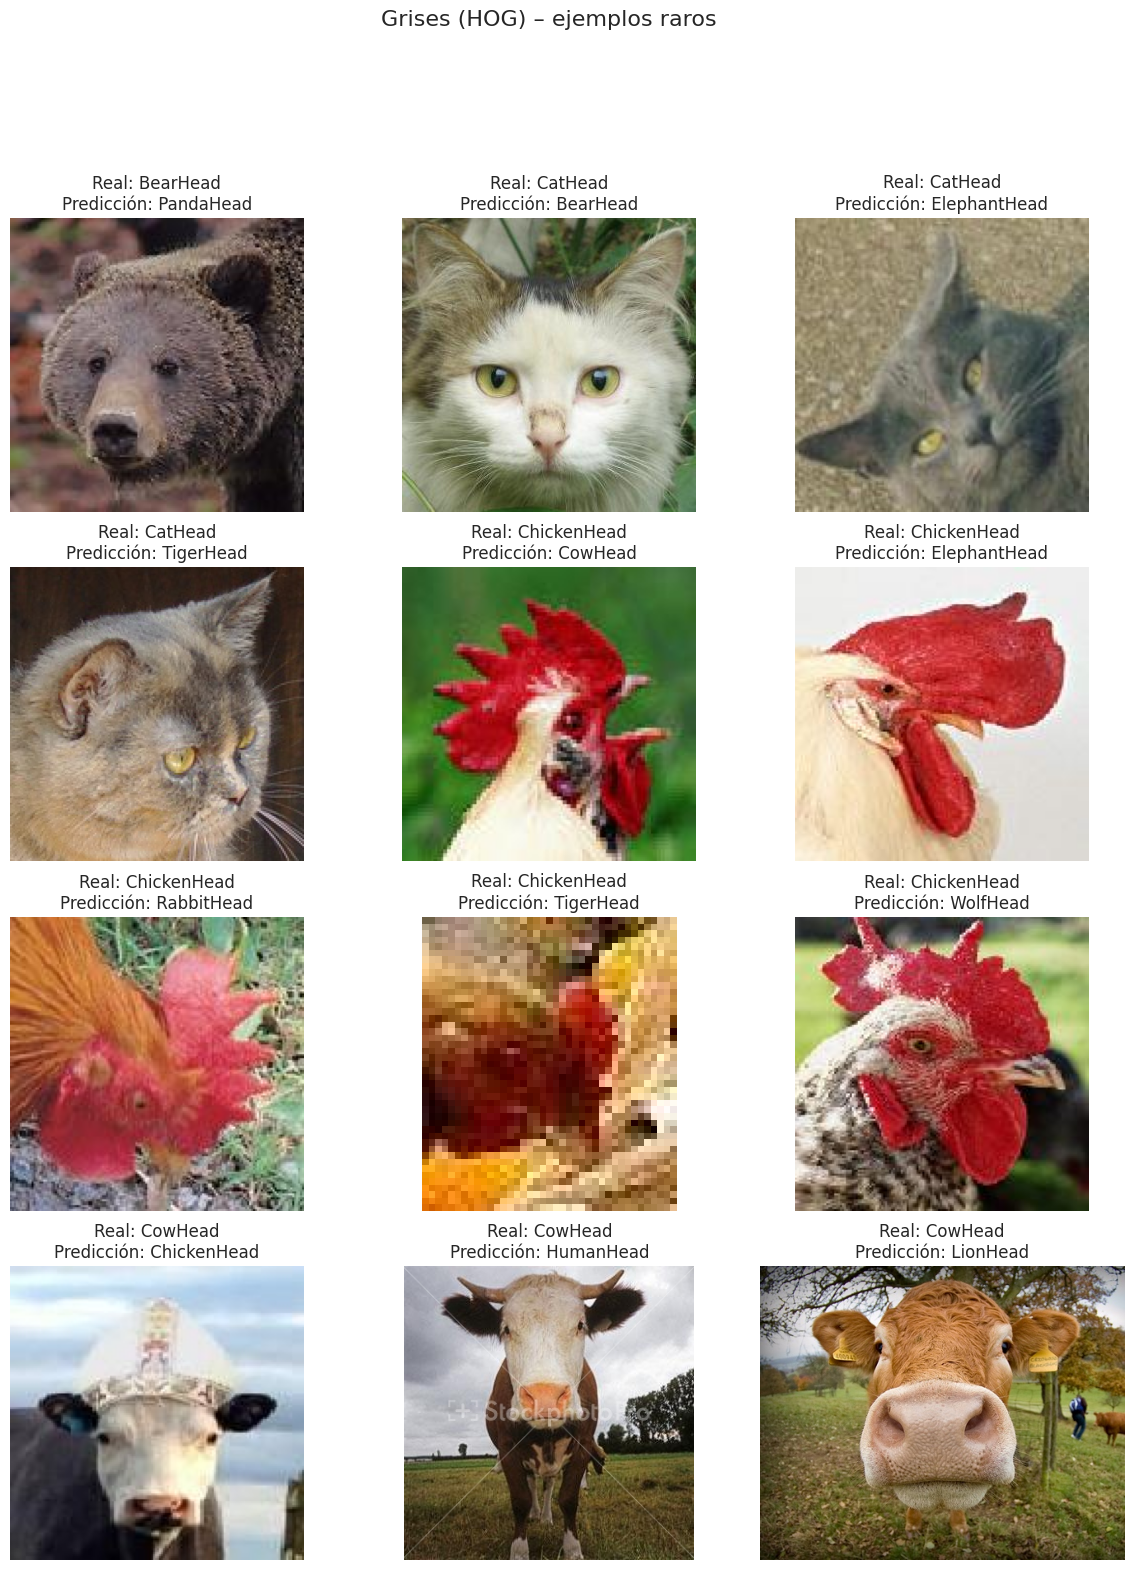

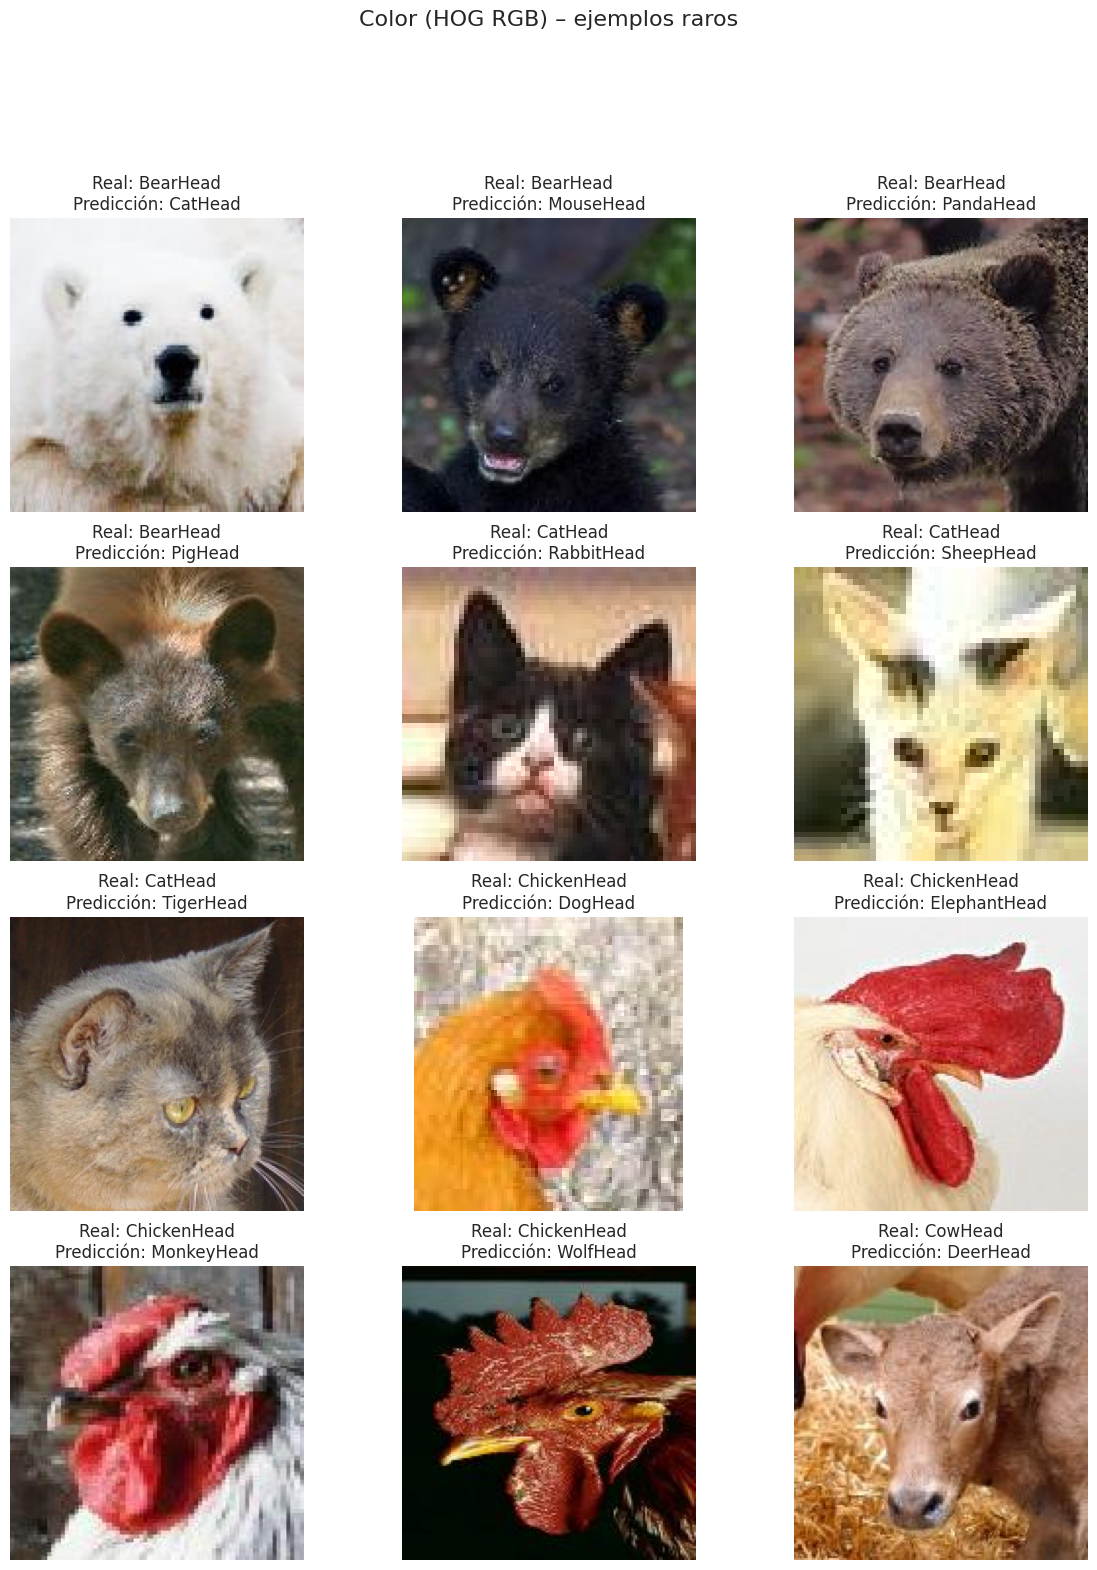

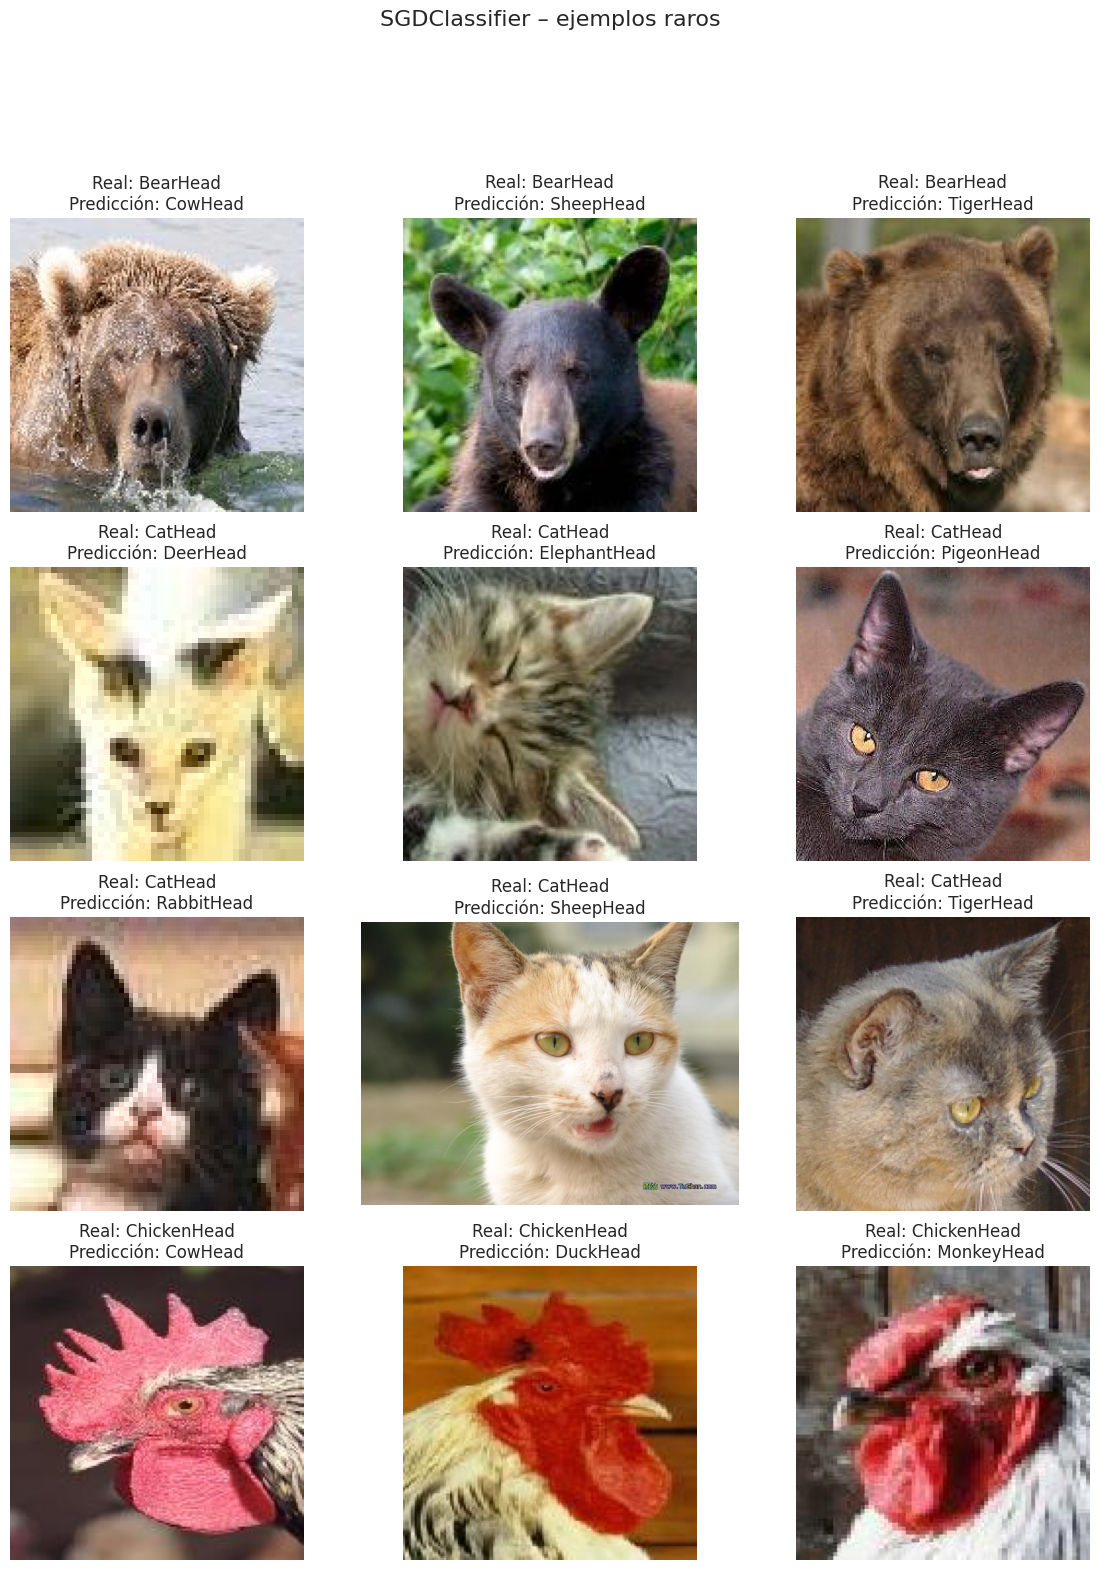

In [35]:
import math

def collect_misclassifications(name: str, predictions_array: np.ndarray) -> pd.DataFrame:
    model_df = dataset_df.copy().reset_index(drop=True)
    model_df['predicted'] = predictions_array
    model_df['actual'] = y
    misclassified = model_df[model_df['actual'] != model_df['predicted']].copy()
    misclassified['actual→predicted'] = misclassified['actual'] + ' → ' + misclassified['predicted']
    if misclassified.empty:
        print(f'{name}: sin clasificaciones erróneas en la validación cruzada.')
        return misclassified
    counts = misclassified['actual→predicted'].value_counts().sort_values()
    print(f'{name}: {len(misclassified)} ejemplos mal clasificados (se muestran combinaciones más raras).')
    display(counts.head(10).to_frame('frecuencia'))
    return misclassified

def plot_misclassified_examples(misclassified_df: pd.DataFrame, title: str, max_examples: int = 12) -> None:
    if misclassified_df.empty:
        return
    pair_counts = misclassified_df['actual→predicted'].map(misclassified_df['actual→predicted'].value_counts())
    rare_sorted = misclassified_df.assign(pair_count=pair_counts).sort_values(['pair_count', 'actual', 'predicted'])
    sample = rare_sorted.head(max_examples)
    num_samples = len(sample)
    cols = 3
    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.ravel():
        ax.axis('off')
    for ax, (_, row) in zip(axes.ravel(), sample.iterrows()):
        try:
            with Image.open(row['original_path']) as image:
                ax.imshow(image)
        except (UnidentifiedImageError, OSError):
            ax.text(0.5, 0.5, 'No se pudo cargar la imagen', ha='center', va='center')
        ax.set_title(f"Real: {row['actual']}\nPredicción: {row['predicted']}")
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

misclassification_reports = {}

for model_name, preds in {
    'Grises (HOG)': predictions['Grises (HOG)'],
    'Color (HOG RGB)': predictions['Color (HOG RGB)'],
    'SGDClassifier': sgd_cv_predictions
}.items():
    misclassification_reports[model_name] = collect_misclassifications(model_name, preds)

for model_name, df_mis in misclassification_reports.items():
    plot_misclassified_examples(df_mis, f'{model_name} – ejemplos raros', max_examples=12)